In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [2]:
def get_direct_link(shared_link):
    return 'https://drive.google.com/uc?export=download&id=' + shared_link.split('/')[-2]

link = "https://drive.google.com/file/d/1nBwIe13D0PN5YxxI18H8R6DTrcQTyg57/view?usp=drive_link"

direct_link = get_direct_link(link)
df = pd.read_csv(direct_link)

In [3]:
df['date'] = pd.to_datetime(df.date, format = '%Y-%m-%d')
df.sort_values(by='date', inplace=True)

In [4]:
train_size = int(0.75 * len(df))
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
print('Fit set rows: '+str(len(train_df)))
print('Test set rows: '+str(len(test_df)))
print(train_df.date.min(),train_df.date.max(),test_df.date.min(),test_df.date.max())

Fit set rows: 21411
Test set rows: 7137
2015-08-07 00:00:00 2021-08-07 00:00:00 2021-08-07 00:00:00 2023-06-03 00:00:00


In [5]:
def build_training_data(features):
    x = np.array(train_df[features])
    y = np.array(train_df['outcome'])
    x = sm.add_constant(x)
    x = x.astype(float)
    return x, y

def train_regression(features):
    x, y = build_training_data(features)
    model = sm.OLS(y, x).fit()
    return model.params

def train_model(wiki=True):
    features = ['inverse_B365_w', 'inverse_B365_d', 'inverse_B365_l']
    if wiki:
        features.append('wikibuzz')
    return train_regression(features)

def model_prob(coef, inv_odds_w, inv_odds_d, inv_odds_l, wikibuzz=None):
    prob = coef[0] + coef[1]*inv_odds_w + coef[2]*inv_odds_d + coef[3]*inv_odds_l
    if wikibuzz:
        prob += coef[4]*wikibuzz
    return prob

def kelly(implied_prob, model_predicted_prob):
    return max(model_predicted_prob - ((1 - model_predicted_prob) / ((1 / implied_prob) - 1)), 0)

def profit(stake, implied_prob, outcome):
    return stake*(1/implied_prob - 1) if outcome == 1 else (-stake if outcome == 0 else 0)

def estimate_probabilities(data, coef, use_wiki=True):
    if use_wiki:
        data['est_prob'] = data.apply(lambda row: model_prob(coef, row['inverse_B365_w'], row['inverse_B365_d'], row['inverse_B365_l'], row['wikibuzz']), axis=1)
    else:
        data['est_prob'] = data.apply(lambda row: model_prob(coef, row['inverse_B365_w'], row['inverse_B365_d'], row['inverse_B365_l']), axis=1)
    return data

def show_results(data, coef, use_wiki=True):
    data = estimate_probabilities(data, coef, use_wiki)
    
    data['original_stake'] = [kelly(a, b) for a, b in zip(data['inverse_B365_w'], data['est_prob'])]
    data['original_profit'] = [profit(a, b, c) for a, b, c in zip(data['original_stake'], data['inverse_B365_w'], data['outcome'])]
    data['post-bet_balance'] = (data['original_profit'] + 1).cumprod()
    data['pre-bet_balance'] = data['post-bet_balance'].shift(1)
    data['correct_stake'] = data['original_stake'] * data['pre-bet_balance']
    data['correct_profit'] = data['original_profit'] * data['pre-bet_balance']
    
    results_summary = {
        'Bets considered (2 * Matches)': len(data[data['inverse_B365_w'].notna()]),
        'Number of bets placed': len(data[(data["original_profit"].notna()) & (data["original_profit"] != 0)]),
        'Mean overround (%)': ((data['inverse_B365_w'] + data['inverse_B365_d'] + data['inverse_B365_l']).mean() - 1)*100,
        'Absolute amount bet': data['correct_stake'].sum(),
        'Absolute return': data['correct_profit'].sum(),
        'ROI (%)': ((((data['correct_profit'].sum() + data['correct_stake'].sum()) / data['correct_stake'].sum()) - 1) * 100)
    }
    
    print(results_summary)
    return results_summary

def plot_results(test_df):
    test_df['cum_profit'] = test_df['correct_profit'].cumsum()

    fig, ax = plt.subplots(figsize=(10, 6))
    
    test_df.plot('date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)

    ax.set_title('Cumulative Profit Over Time', fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)

    ax.tick_params(axis='both', labelsize=12)

    ax.grid(visible=True, linestyle='--', alpha=0.6)

    plt.show()
    
def plot_results_save(test_df, filename, title):
    test_df['cum_profit'] = test_df['correct_profit'].cumsum()

    fig, ax = plt.subplots(figsize=(10, 6))

    test_df.plot('date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)

    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)

    ax.tick_params(axis='both', labelsize=12)

    ax.grid(visible=True, linestyle='--', alpha=0.6)

    # Save the plot
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

{'Bets considered (2 * Matches)': 7137, 'Number of bets placed': 145, 'Mean overround (%)': 5.400061856777794, 'Absolute amount bet': 1.900208367697678, 'Absolute return': 0.15553383398278156, 'ROI (%)': 8.185093625875805}


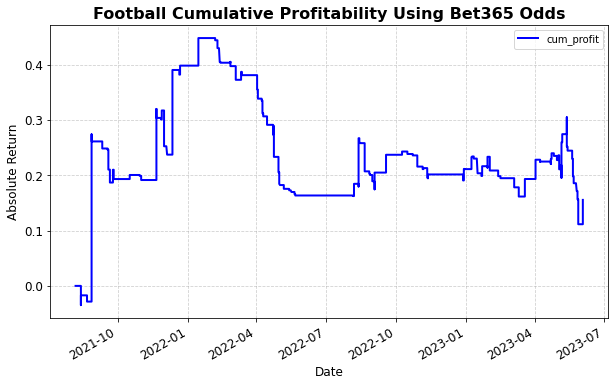

In [6]:
coef = train_model()
show_results(test_df, coef)
plot_results_save(test_df, 'football.png', "Football Cumulative Profitability Using Bet365 Odds")

In [7]:
coef

array([ 0.47536486,  0.53340678, -0.50297777, -0.45147054, -0.01416805])

In [8]:
1 + coef[3]

0.5485294601544113

In [9]:
test_df.sort_values(by=['correct_profit'], ascending=False)

,match_id,team,date,year,wikibuzz,inverse_B365_w,inverse_B365_d,inverse_B365_l,FTR,outcome,est_prob,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
207,7078,Empoli,2021-08-28,2021,-2.596498,0.083333,0.153846,0.819672,A,1,0.109164,0.028179,0.309964,1.272763,0.971601,0.027378,0.301162,0.272763
1563,4181,Bordeaux,2021-12-12,2021,-4.096287,0.312500,0.285714,0.454545,A,1,0.351169,0.056246,0.123741,1.390487,1.237373,0.069597,0.153114,0.390487
1229,4179,St Etienne,2021-11-21,2021,-3.896745,0.322581,0.307692,0.421941,A,1,0.357385,0.051377,0.107892,1.320012,1.191462,0.061214,0.128549,0.320012
3663,586,Torino,2022-08-13,2022,-3.337386,0.363636,0.303030,0.384615,A,1,0.390555,0.042301,0.074027,1.267099,1.179765,0.049905,0.087334,0.267099
6743,13074,Cremonese,2023-05-06,2023,-3.135494,0.425532,0.294118,0.333333,H,1,0.448345,0.039712,0.053612,1.259654,1.195557,0.047479,0.064096,0.259654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6817,3606,Chelsea,2023-05-13,2023,-2.160773,0.666667,0.222222,0.166667,D,0,0.674565,0.023696,-0.023696,1.273994,1.304915,0.030921,-0.030921,0.273994
46,9113,Strasbourg,2021-08-14,2021,-2.874219,0.076923,0.142857,0.833333,H,0,0.109039,0.034792,-0.034792,0.965208,1.000000,0.034792,-0.034792,-0.034792
435,7079,Milan,2021-09-19,2021,-2.890372,0.285714,0.294118,0.476190,D,0,0.305797,0.028116,-0.028116,1.211346,1.246389,0.035043,-0.035043,0.211346
1382,4180,Lorient,2021-12-01,2021,-3.940858,0.333333,0.303030,0.421941,H,0,0.366090,0.049135,-0.049135,1.252525,1.317248,0.064723,-0.064723,0.252525


In [10]:
test_df.sort_values(by=['wikibuzz'], ascending=False)

,match_id,team,date,year,wikibuzz,inverse_B365_w,inverse_B365_d,inverse_B365_l,FTR,outcome,est_prob,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
1565,4181,Troyes,2021-12-12,2021,4.096287,0.454545,0.285714,0.312500,A,0,0.374994,0.000000,-0.000000,1.390487,1.390487,0.000000,-0.000000,0.390487
1352,4180,Troyes,2021-12-01,2021,3.940858,0.421941,0.303030,0.333333,H,1,0.341689,0.000000,0.000000,1.317248,1.317248,0.000000,0.000000,0.317248
1197,4179,Troyes,2021-11-21,2021,3.896745,0.421941,0.307692,0.322581,A,0,0.344824,0.000000,-0.000000,1.191462,1.191462,0.000000,-0.000000,0.191462
3659,586,Monza,2022-08-13,2022,3.337386,0.384615,0.303030,0.363636,A,0,0.316648,0.000000,-0.000000,1.182643,1.182643,0.000000,-0.000000,0.182643
6732,13074,Spezia,2023-05-06,2023,3.135494,0.333333,0.294118,0.425532,H,0,0.268694,0.000000,-0.000000,1.218116,1.218116,0.000000,-0.000000,0.218116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6743,13074,Cremonese,2023-05-06,2023,-3.135494,0.425532,0.294118,0.333333,H,1,0.448345,0.039712,0.053612,1.259654,1.195557,0.047479,0.064096,0.259654
3663,586,Torino,2022-08-13,2022,-3.337386,0.363636,0.303030,0.384615,A,1,0.390555,0.042301,0.074027,1.267099,1.179765,0.049905,0.087334,0.267099
1229,4179,St Etienne,2021-11-21,2021,-3.896745,0.322581,0.307692,0.421941,A,1,0.357385,0.051377,0.107892,1.320012,1.191462,0.061214,0.128549,0.320012
1382,4180,Lorient,2021-12-01,2021,-3.940858,0.333333,0.303030,0.421941,H,0,0.366090,0.049135,-0.049135,1.252525,1.317248,0.064723,-0.064723,0.252525


In [11]:
test_df.wikibuzz.nlargest(5)

1565    4.096287
1352    3.940858
1197    3.896745
3659    3.337386
6732    3.135494
Name: wikibuzz, dtype: float64

In [12]:
test_df.correct_stake.nlargest(5)

6808    0.090430
1563    0.069597
1382    0.064723
1229    0.061214
5174    0.054463
Name: correct_stake, dtype: float64

Most profitable two bets are against Troyes in Nov/Dec 2021, they had just been promoted and bought by the highly successful City football group. Both are home games and before the game against St Ettiene they had won 2 and drawn 2 of their last 4 games. Due to all these reasons they had the 3 highest wikibuzz scores of the whole dataset during this period for home games and 2/3 of these bets came in, more than doubling the stake each time. In general the top 4 most profitable bets came from 4 of the 5 highest wikibuzz factors. 

In [13]:
test_df.loc[test_df.match_id == 7078]

,match_id,team,date,year,wikibuzz,inverse_B365_w,inverse_B365_d,inverse_B365_l,FTR,outcome,est_prob,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
207,7078,Empoli,2021-08-28,2021,-2.596498,0.083333,0.153846,0.819672,A,1,0.109164,0.028179,0.309964,1.272763,0.971601,0.027378,0.301162,0.272763
218,7078,Juventus,2021-08-28,2021,2.596498,0.819672,0.153846,0.083333,A,0,0.760792,0.000000,-0.000000,1.272763,1.272763,0.000000,-0.000000,0.272763


In [14]:
test_df.loc[test_df.match_id == 4181]

,match_id,team,date,year,wikibuzz,inverse_B365_w,inverse_B365_d,inverse_B365_l,FTR,outcome,est_prob,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
1563,4181,Bordeaux,2021-12-12,2021,-4.096287,0.312500,0.285714,0.454545,A,1,0.351169,0.056246,0.123741,1.390487,1.237373,0.069597,0.153114,0.390487
1565,4181,Troyes,2021-12-12,2021,4.096287,0.454545,0.285714,0.312500,A,0,0.374994,0.000000,-0.000000,1.390487,1.390487,0.000000,-0.000000,0.390487


In [15]:
test_df.loc[test_df.match_id == 4179]

,match_id,team,date,year,wikibuzz,inverse_B365_w,inverse_B365_d,inverse_B365_l,FTR,outcome,est_prob,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
1197,4179,Troyes,2021-11-21,2021,3.896745,0.421941,0.307692,0.322581,A,0,0.344824,0.000000,-0.000000,1.191462,1.191462,0.000000,-0.000000,0.191462
1229,4179,St Etienne,2021-11-21,2021,-3.896745,0.322581,0.307692,0.421941,A,1,0.357385,0.051377,0.107892,1.320012,1.191462,0.061214,0.128549,0.320012


In [16]:
test_df.loc[test_df.match_id == 586]

,match_id,team,date,year,wikibuzz,inverse_B365_w,inverse_B365_d,inverse_B365_l,FTR,outcome,est_prob,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
3659,586,Monza,2022-08-13,2022,3.337386,0.384615,0.30303,0.363636,A,0,0.316648,0.000000,-0.000000,1.182643,1.182643,0.000000,-0.000000,0.182643
3663,586,Torino,2022-08-13,2022,-3.337386,0.363636,0.30303,0.384615,A,1,0.390555,0.042301,0.074027,1.267099,1.179765,0.049905,0.087334,0.267099


In [17]:
test_df.loc[test_df.match_id == 13074]

,match_id,team,date,year,wikibuzz,inverse_B365_w,inverse_B365_d,inverse_B365_l,FTR,outcome,est_prob,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
6732,13074,Spezia,2023-05-06,2023,3.135494,0.333333,0.294118,0.425532,H,0,0.268694,0.000000,-0.000000,1.218116,1.218116,0.000000,-0.000000,0.218116
6743,13074,Cremonese,2023-05-06,2023,-3.135494,0.425532,0.294118,0.333333,H,1,0.448345,0.039712,0.053612,1.259654,1.195557,0.047479,0.064096,0.259654


In [18]:
test_df.loc[test_df.match_id == 4180]

,match_id,team,date,year,wikibuzz,inverse_B365_w,inverse_B365_d,inverse_B365_l,FTR,outcome,est_prob,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
1352,4180,Troyes,2021-12-01,2021,3.940858,0.421941,0.30303,0.333333,H,1,0.341689,0.000000,0.000000,1.317248,1.317248,0.000000,0.000000,0.317248
1382,4180,Lorient,2021-12-01,2021,-3.940858,0.333333,0.30303,0.421941,H,0,0.366090,0.049135,-0.049135,1.252525,1.317248,0.064723,-0.064723,0.252525


In [19]:
test_df.loc[(test_df.team == 'Troyes') & ((test_df.year == 2021)|(test_df.year == 2022))]

,match_id,team,date,year,wikibuzz,inverse_B365_w,inverse_B365_d,inverse_B365_l,FTR,outcome,est_prob,original_stake,original_profit,post-bet_balance,pre-bet_balance,correct_stake,correct_profit,cum_profit
1,4173,Troyes,2021-08-07,2021,0.323012,0.090909,0.166667,0.800000,A,0,0.074274,0.000000,-0.000000,1.000000,1.000000,0.000000,-0.000000,0.000000
84,3608,Troyes,2021-08-15,2021,0.001109,0.263158,0.294118,0.500000,H,0,0.242049,0.000000,-0.000000,0.982935,0.982935,0.000000,-0.000000,-0.017065
174,9606,Troyes,2021-08-22,2021,-0.016761,0.266667,0.294118,0.500000,D,0,0.244174,0.000000,-0.000000,0.982880,0.982880,0.000000,-0.000000,-0.017120
270,4174,Troyes,2021-08-29,2021,-0.035091,0.230947,0.277778,0.546448,A,0,0.212629,0.000000,-0.000000,1.261273,1.261273,0.000000,-0.000000,0.261273
366,5536,Troyes,2021-09-12,2021,0.265983,0.307692,0.303030,0.444444,A,1,0.282650,0.000000,0.000000,1.248475,1.248475,0.000000,0.000000,0.248475
425,4175,Troyes,2021-09-19,2021,0.614188,0.408163,0.285714,0.357143,D,0,0.379433,0.000000,-0.000000,1.246389,1.246389,0.000000,-0.000000,0.246389
514,8786,Troyes,2021-09-22,2021,-0.845575,0.117647,0.222222,0.714286,H,0,0.115847,0.000000,-0.000000,1.186926,1.186926,0.000000,-0.000000,0.186926
614,4176,Troyes,2021-09-26,2021,0.354286,0.363636,0.312500,0.370370,D,0,0.339920,0.000000,-0.000000,1.193227,1.193227,0.000000,-0.000000,0.193227
677,5666,Troyes,2021-10-03,2021,0.155360,0.200000,0.285714,0.571429,H,0,0.178154,0.000000,-0.000000,1.193227,1.193227,0.000000,-0.000000,0.193227
804,4177,Troyes,2021-10-17,2021,0.585978,0.230947,0.277778,0.540541,H,1,0.206497,0.000000,0.000000,1.200577,1.200577,0.000000,0.000000,0.200577


# Removing empoli

{'Bets considered (2 * Matches)': 7136, 'Number of bets placed': 144, 'Mean overround (%)': 5.400021904426899, 'Absolute amount bet': 1.4503575049576387, 'Absolute return': -0.11788918632059475, 'ROI (%)': -8.128284641381445}


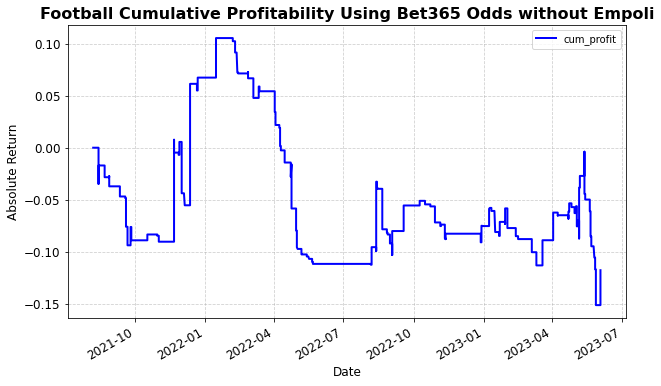

In [20]:
test_df.drop(index=207, inplace=True)
coef = train_model()
coef = train_model()
show_results(test_df, coef)
plot_results_save(test_df, 'football_2.png' , "Football Cumulative Profitability Using Bet365 Odds without Empoli")